# A TUTORIAL ON CHANGE OF VARIABLES IN MCMC SIMULATIONS

by Sebastian T. Glavind, July 2022

In [1]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
%matplotlib inline

# Introduction

In Markov chain Monte Carlo (MCMC) simulations it is often the case that the proposal distribution and the target distribution have different supports. For example, often a Gaussian distribution is used as proposal distribution, which has full support along its dimensions, and we may be insterested in a target distribution, where some of its dimensions correspond to non-negative random variables. In this tutorial, we will consider how to deal with such situations.

# Case I: A non-negative target distribution

For the sake of illustration, we will consider the simple target distribution $Gamma(3,1)$, which has non-negative support. 

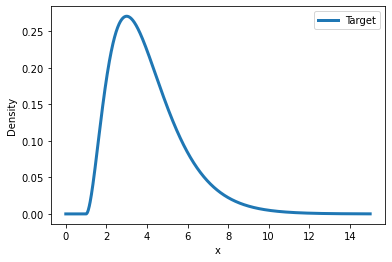

In [2]:
xv = np.linspace(0, 15, 1000)
yv = stats.gamma(3,1).pdf(xv)

plt.plot(xv,yv, linewidth=3)
plt.xlabel('x')
plt.ylabel('Density')
plt.legend(['Target'])
plt.show()

## Correct, inefficient implementation

Suppose we want to sample from our target distribution with a Gaussian random walk Metropolis algorithm. The basis for this implementation, as well as most MCMC algorithms, is the Metropolis-Hastings acceptance probability, i.e, 

$$
p_{acc}(x^*|x) = \min \left\{ 1, r_{acc} \right\}, \text{where} \ r_{acc} = \frac{p(x^*) q(x|x^*)}{p(x) q(x^*|x)},
$$

which provides the probability of accepting proposal value $x^*$ given the current state $x$. Here, $p(x^*)$ and $q(x^*|x)$ denotes the target and proposal distribution, respectively, evaluated at the proposal value. For a Gaussian proposal distibution $q(x^*|x)=q(x|x^*)$, i.e., it is summetric, and thus the Metropolis-Hastings acceptance ratio $r_{acc}$ simplifies to Metropolis acceptance ratio, i.e.,

$$
r_{acc} = \frac{p(x^*)}{p(x)}.
$$

This approach to sampling from our target is prefectly fine, as negative proposals are simply rejected. However, it can result in a unnecessarily high rejection rate and thus be inefficient. Furthermore, note that we log-transform the expression above in the numerical implementations for numerical stability, thus $\log(r_{acc}) = \log(p(x^*)) - \log(p(x))$.

In [3]:
# Target distritution (log-posterior for numerical stability)
def log_pos1(x):
    logPos = stats.gamma(3,1).logpdf(x)
    return(logPos)  

# Metropolis algorithm
def Metropolis(x, T, log_pos, delta=1, dim=1):
    counter=0
    samp = np.zeros([T, dim])
    samp[0,:] = x
    lp_cur = log_pos(x)
    for t in range(1,T,1):
        x_pro = samp[t-1,:] + np.random.normal(size=dim)*delta
        lp_pro = log_pos(x_pro)
        ratio_pro = lp_pro - lp_cur
        if np.log(np.random.uniform()) < ratio_pro: 
            counter += 1
            samp[t] = x_pro
            lp_cur = lp_pro
        else:
            samp[t,:] = samp[t-1,:]
    return(samp, counter)

In [4]:
# Sampling
np.random.seed(42)
x1=2; T1=20000
samp1, counter1 = Metropolis(x1, T1, log_pos1, delta=3)
print('Acceptance rate: ' , np.round(counter1/T1,3))

Acceptance rate:  0.501


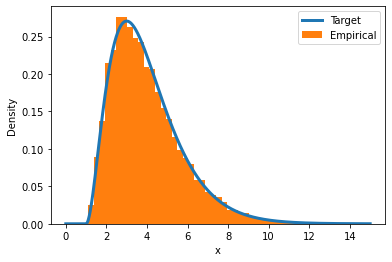

In [5]:
# Plot samples
def plot_samplesDensity(samp, xt, yt):
    plt.plot(xt,yt, linewidth=3)
    plt.hist(samp, bins=48, density=True)
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend(['Target', 'Empirical'])
    plt.show()

plot_samplesDensity(samp1, xv, yv)

We see that the sampler manages to capture the target distribution, i.e., the target and empirical PDF coincide. However, as we see from the plot below, which show the rejection rate versus the current state (binned), the highest rejection rates are observed for the lower binnes, thus a lot of propsals near zero are rejected. This is expected since, a current state near zero is more likely to propose a negative state, which leads to an automatic rejections in the present implementation.

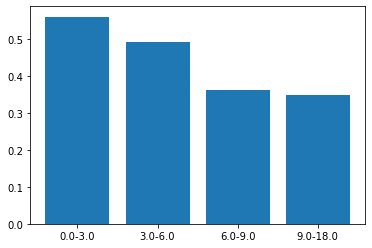

In [6]:
# Plot rejection rate versus current state (binned)
# https://barumpark.com/blog/2019/Jacobian-Adjustments/
def plot_rejection_byInt(samp, samp_bins = np.array([0., 3., 6., 9., 18.])):
    samp = samp.reshape(-1)
    samp_diff = np.diff(samp)
    samp_state = samp[:-1]
    samp_state_binned = np.digitize(samp_state, samp_bins)
    n_bins = len(samp_bins) - 1
    samp_int_reject = np.zeros([n_bins])
    labels=[]
    for i in range(1, n_bins+1):
        sir = samp_diff[samp_state_binned==i]
        samp_int_reject[i-1] = sum(sir==0)/len(sir)
        labels.append( str(samp_bins[i-1]) + '-' + str(samp_bins[i]) )
    x_lab = np.arange(1, n_bins+1, 1)
    plt.bar(x_lab, samp_int_reject)
    plt.xticks(x_lab, labels, rotation='horizontal')
    plt.show()

plot_rejection_byInt(samp1)

## Incorrect implementation of transformation

Now, one might wonder whether we could use a proposal distribution that is strictly positive and thereby get rid of the negative proposal values? One way of doing so is to sample on the log-scale, i.e., we keep the Normally distributed proposal distribution but sample

$$
\log(x^*) = \mathcal{N}( \log(x), \delta )
$$

and then use $x^*=\exp\{\log(x^*)\}$ as our proposal value. This thus ensures that all proposals will be strictly positive, which remedies the high rejection rate near zero (i.e., for $x \approx 0$) observed above.

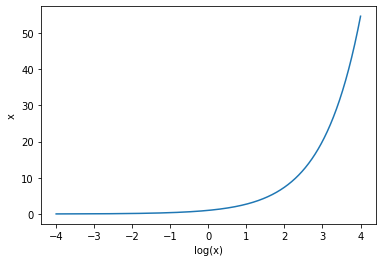

In [7]:
# Plot transformation
x_log = np.linspace(-4, 4, 1000)
y_log = np.exp(x_log)

plt.plot(x_log, y_log)
plt.xlabel('log(x)')
plt.ylabel('x')
plt.show()

In [8]:
# Target distritution (log scale for posterior - numerical stability)
def log_pos2(x):
    x = np.exp(x)
    logPos = stats.gamma(3,1).logpdf(x)
    return(logPos)

In [9]:
# Sampling
np.random.seed(42)
x2=np.log(2); T2=20000
samp2, counter2 = Metropolis(x2, T2, log_pos2, delta=0.9)
samp2 = np.exp(samp2);
print('Acceptance rate: ' , np.round(counter2/T2,3))

Acceptance rate:  0.489


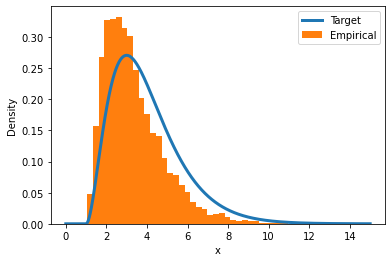

In [10]:
# Plot samples
plot_samplesDensity(samp2, xv, yv)

This (naive) implementation introduces a bias, as it is appears from the figure above, i.e., the target and empirical PDF do not coincide! The reason for this discrepancy is that under a nonlinear change of variable, a probability density transforms differently from a simple function, due to the Jacobian factor (Bishop, 2006).

-----------

Bishop, C. M., Pattern recognition and machine learning, Springer, 2006.

-----------

## Correct implementation of transformation

### The Jacobien factor

The missing link here is to account for the change of volumen when transforming variables, which the change of variables principle provides the machanics for. For the univeriate case, the change of variables principle states (Wasserman, 2004) that the distribution of $V=g(W)$ (i.e., $W = g^{-1}(V)$ is the inverse transformation), where $W$ is a continuous random variable with PDF $q_{w}(w)$, is given by

$$
\begin{align}
q_{v}(v) &= q_{w}(w) \left| \frac{d w}{d v} \right| \\
&= q_{w}(g^{-1}(v)) \left| \frac{d g^{-1}(v)}{d v} \right|.
\end{align}
$$

As a consequence of this property, the concept of the maximum of a probability density is dependent on the choice of variable (Bishop, 2006). We can understand this result more intuitively, as observations falling in the range $(w, w + \delta w)$ will get transformed into $(v, v + \delta v)$, where $p_w(w) \delta w \approx p_v(v)\delta v$, and thus $q_v(v) \approx q_w(w)|\delta w / \delta v|$. The term $| d w / d v |$ is the Jacobian factor, which accouns for the change of volumen, see Wasserman (2004) and Bishop (2006) for further details.

The multivariate extension of the change of variable principle follows immiedietly, i.e., we simply replace the univariate Jacobian factor by the determinant of the Jacobian matrix, which aligns with the general finding from algebra that the determinent of a transformation matrix defines the change of volumen resulting from the transform. For the multivariate case, the change of variables principle thus states

$$
\begin{align}
q_{v}(\mathbf{v}) &= q_{w}(\mathbf{w}) \left| \frac{d \mathbf{w}}{d \mathbf{v}} \right| \\
&= q_{w}(g^{-1}(\mathbf{v})) \left| \text{det}(J_{v,w}) \right|^{-1},
\end{align}
$$

where $J_{v,w}$ is the Jacobian matrix of partial derivatives of $v_i$ with respect to $w_j$, i.e., $J_{v,w} = \{d v_i / d w_j\}_{i,j}$. In most cases, each dimension has it own transformation function, which depends only on that dimention, whereby the $J_{v,w}$ becomes diagonal. Thus, the computation of its determinant simplifies to the product of the inverse absolute value of the gradient of each transformation function, see e.g., Goulet (2020) for further details. 

-----------

Wasserman, L., All of statistics: a concise course in statistical inference, Springer, 2004.

Goulet, J. A., Probabilistic machine learning for civil engineers. MIT Press, 2020.

-----------

### Back to our problem

Our proposal $w=\log(x^*)$ is Normally distributed with mean $\log(x)$ and standard deviation $\delta$, but we are interested in the distribution of $v=g(w)=x^*$ such that $x^* \geq 0$. Thus, the mapping that transforms $w=\log(x^*)$ to $v=x^*$ is the exponential function $g(w)=\exp(w)$, and its inverse transfromation is the natural logarithm $g^{-1}(v)=\log(v)$. Considering this setting within the transformation of variables principle, we arrive at

$$
\begin{align}
q_{v}(v) &= q_{w}(g^{-1}(v)) \left| \frac{d g^{-1}(v)}{d v} \right| \\
&= q_{w}(\log(x^*)) \left| \frac{d \log(x^*)}{d x^*} \right| \\
&= q_{w}(\log(x^*)) \left| \frac{1}{x^*} \right| \\
&= q_{w}(\log(x^*)) \frac{1}{x^*},
\end{align}
$$

as $x^* \geq 0$. Note again that we use the log-transform of the expression above for numerical stability, thus $\log q_v(v) = \log q_w(\log(x^*)) - \log(x^*)$.

### The Hastings correction

Due to the change of variable in our proposal distribution, it is no longer symmetric, as $1/x^*$ only equals $1/x$ when $x^*=x$. Thus, we need to consider the general Metropolis-Hastings acceptance probability stated above, i.e.,

$$
p_{acc}(x^*|x) = \min \left\{ 1, r_{acc} \right\}, \text{where} \ r_{acc} = \frac{p(x^*)}{p(x)} \frac{q_{v}(x|x^*)}{q_{v}(x^*|x)},
$$

which for our case simplifies to

$$
r_{acc} = \frac{p(x^*)}{p(x)} \frac{q_{w}(\log(x)) \frac{1}{x}}{q_{w}(\log(x^*)) \frac{1}{x^*}} = \frac{p(x^*)}{p(x)} \frac{\frac{1}{x}}{\frac{1}{x^*}} = \frac{p(x^*)}{p(x)} \frac{x^*}{x},
$$

as $q_w(w)$ is still Gaussian and thus symmetric, i.e., $q_{w}(w^*|w)=q_{w}(w|w^*)$. Again, we use the log-transform of the expression above for numerical stability, whereby the acceptance ratio states

$$
\log(r_{acc}) = (\log(p(x^*)) + \log(x^*)) - (\log(p(x)) + \log(x)).
$$

Note that the terms above group into terms involving the proposal $x^*$ only, and the current state $x$ only, which we take advantage of in the implementation below.

In [11]:
# Target distritution (log scale for posterior - numerical stability)
def log_pos3(x):
    x = np.exp(x)
    logPos = stats.gamma(3,1).logpdf(x) + np.log(x) # including Hastings correction
    return(logPos)

In [12]:
# Sampling
np.random.seed(42)
x3=np.log(2); T3=20000
samp3, counter3 = Metropolis(x3, T3, log_pos3, delta=0.9)
samp3 = np.exp(samp3);
print('Acceptance rate: ' , np.round(counter3/T3,3))

Acceptance rate:  0.492


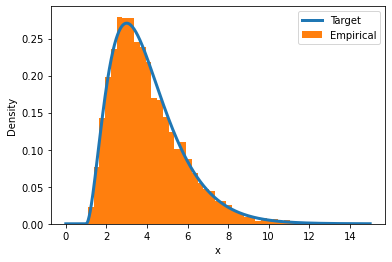

In [13]:
# Plot samples
plot_samplesDensity(samp3, xv, yv)

We see that the sampler again manages to capture the target distribution. Furthermore, as we see from the plot below, which show the rejection rate versus the current state (binned), the rejection rates are now uniformly distributed over the range of current states.

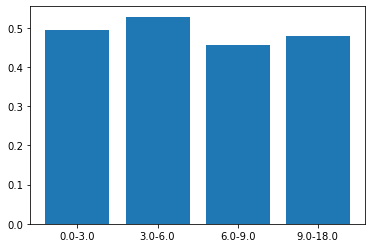

In [14]:
# Plot rejection rate versus current state (binned)
plot_rejection_byInt(samp3)

# Case II: A target distribution with an upper and lower limit 

For the sake of illustration, we will consider the simple target distribution $Beta(2,2)$, which is confined within the interval $[0,1]$. 

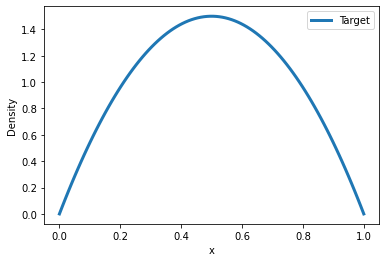

In [15]:
# Plot target denesity
xv2 = np.linspace(0, 1, 100)
yv2 = stats.beta(2,2).pdf(xv2)

plt.plot(xv2,yv2, linewidth=3)
plt.xlabel('x')
plt.ylabel('Density')
plt.legend(['Target'])
plt.show()

## Correct, inefficient implementation

Again, we start by sampling from our target distribution with a Gaussian random walk Metropolis algorithm.

In [16]:
# Target distribution (log-posterior for numerical stability)
def log_pos21(x):
    logPos = stats.beta(2,2).logpdf(x)
    return(logPos)

In [17]:
# Sampling
np.random.seed(42)
x21=0.8; T21=20000
samp21, counter21 = Metropolis(x21, T21, log_pos21, delta=0.5)
print('Acceptance rate: ' , np.round(counter21/T21,3))

Acceptance rate:  0.501


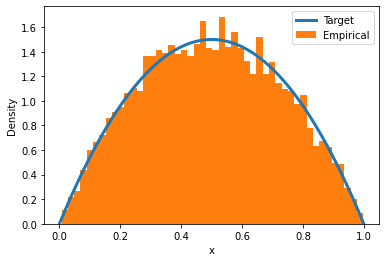

In [18]:
# Plot samples
plot_samplesDensity(samp21, xv2, yv2)

We see that the sampler manages to capture the target distribution, i.e., the target and empirical PDF coincide. 

In [19]:
# plot_rejection_byInt(samp21, samp_bins = np.round(np.arange(0,1.2,0.2),2))

## Correct implementation of transformation

A common transform for the case where the target distribution is confined in a an interval $[a,b]$ is the transform,

$$
g(w) = \frac{b \exp(w) + a}{\exp(w) + 1}
$$

with the invers being the so-called logistic sigmoid, i.e,

$$
g^{-1}(v) = \log \left( \frac{v-a}{b-v} \right).
$$

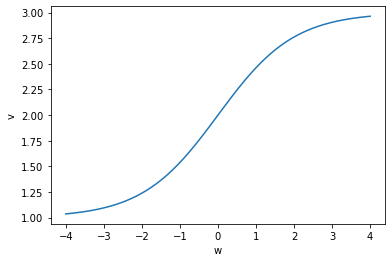

In [20]:
# Plot transformation
x_ls = np.linspace(-4, 4, 1000)
y_ls = (3 * np.exp(x_ls) + 1) / (np.exp(x_ls) + 1)

plt.plot(x_ls, y_ls)
plt.xlabel('w')
plt.ylabel('v')
plt.show()

### The Jacobian factor

For this case, the change of variables principle amounts to

$$
\begin{align}
q_{v}(v) &= q_{w}(g^{-1}(v)) \left| \frac{d g^{-1}(v)}{d v} \right| \\
&= q_{w}(g^{-1}(v)) \left| \frac{b-a}{(b-v)(v-a)} \right|
\end{align}
$$

### The Hastings correction

The general Metropolis-Hastings acceptance ratio for this case simplifies to

$$
r_{acc} = \frac{p(x^*)}{p(x)} \frac{q_{v}(x|x^*)}{q_{v}(x^*|x)} = \frac{p(x^*)}{p(x)} \frac{q_{w}(w) \frac{b-a}{(b-x)(x-a)}}{q_{w}(w) \frac{b-a}{(b-x^*)(x^*-a)}} = \frac{p(x^*)}{p(x)} \frac{(b-x^*)(x^*-a)}{(b-x)(x-a)}.
$$

as $q_w(w)$ is still Gaussian and thus symmetric, i.e., $q_{w}(w^*|w)=q_{w}(w|w^*)$. Again, we use the log-transform of the expression above for numerical stability, whereby the acceptance ratio states

$$
\log(r_{acc}) = \{ \log(p(x^*)) + \log(b-x^*) + \log(x^*-a) \} - \{ \log(p(x)) + \log(b-x) + \log(x-a) \}.
$$

Note that the terms above group into terms involving the proposal $x^*$ only, and the current state $x$ only, which we take advantage of in the implementation below.

In [21]:
# Target distribution (log-posterior for numerical stability)
def log_pos22(x):
    x = np.exp(x)
    x = x / (x + 1)
    logPos = stats.beta(2,2).logpdf(x) + np.log(1-x) + np.log(x) # including Hastings correction
    return(logPos)

In [22]:
# Sampling
np.random.seed(42)
x22=-1; T22=20000
samp22, counter22 = Metropolis(x22, T22, log_pos22, delta=2.2)
samp22 = np.exp(samp22); samp22 = samp22 / (samp22 + 1)
print('Acceptance rate: ' , np.round(counter22/T22,3))

Acceptance rate:  0.498


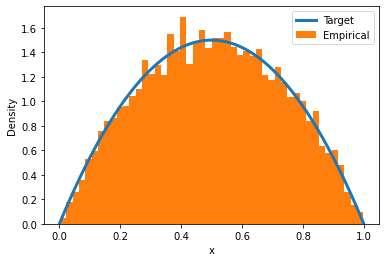

In [23]:
# Plot samples
plot_samplesDensity(samp22, xv2, yv2)

Again, we see that the sampler manages to capture the target distribution, i.e., the target and empirical PDF coincide. 

In [24]:
# plot_rejection_byInt(samp22, samp_bins = np.round(np.arange(0,1.2,0.2),2))

# Case III: A multivariate target distribution with non-negative parameters

For the sake of illustration, we will consider the fitting of the two dimensional Gaussian distribution $Normal(\boldsymbol\mu, \boldsymbol\Sigma)$ based on an observed data sample $\mathcal{D}$. Thus, we are interested in finding the mean vector $\boldsymbol\mu$ and covariance matrix $\boldsymbol\Sigma$, where, as a further simplification, $\boldsymbol\Sigma$ is assumed to be diagonal. That is, our target is the joint distribution of the parameters $\boldsymbol\theta = \{ \mu_1, \mu_2, \sigma_1, \sigma_2\}$.

In [25]:
###########################################################################
# Objective functions and corresponding gradients
###########################################################################

# objective function A: Quadratic function
def objective31(xx):
    row, col = xx[0].shape
    xm = np.vstack([xx[0].reshape(-1), xx[1].reshape(-1)]).T
    mu = np.array([2,3])
    Sigma = np.diag([2,1])
    density = stats.multivariate_normal(mean = mu, cov=Sigma).pdf(xm)
    density = density.reshape(row,col)
    # Output
    return( density )

def sample_objective31(N):
    mu = np.array([2,3]).reshape(2,1)
    Sigma = np.diag([2,1])
    L = np.linalg.cholesky(Sigma) # Cholesky decomposition, i.e. covariance = L.dot(L.T), see e.g. Rasmussen and Williams (2006)
    Z = np.random.normal(size=(2,N)) # Standard Mormal random draws
    X = L.dot(Z) + mu # Apply the transformation
    return(X)

###########################################################################
# Plotting function for objective function 
###########################################################################

def plot_objective(xx_grid, obj_grid, plot_title):
    # create a surface plot with the jet color scheme
    fig = plt.figure(figsize=(16,6))
    fig.subplots_adjust(wspace=0.3)

    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(xx_grid[0], xx_grid[1], obj_grid, cmap='jet')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$p(x_1, x_2)$')

    ax = fig.add_subplot(1, 2, 2)
    con = ax.contourf(xx_grid[0], xx_grid[1], obj_grid, levels=50, cmap='jet')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_aspect('equal')

    # Add colorbar and title
    fig.subplots_adjust(right=0.8)
    cbar = fig.colorbar(con)
    cbar.ax.set_ylabel('$p(x_1, x_2)$')
    fig.suptitle(plot_title, fontsize=13, y=0.95)

    # show the plot
    plt.show()

## Plot objective function

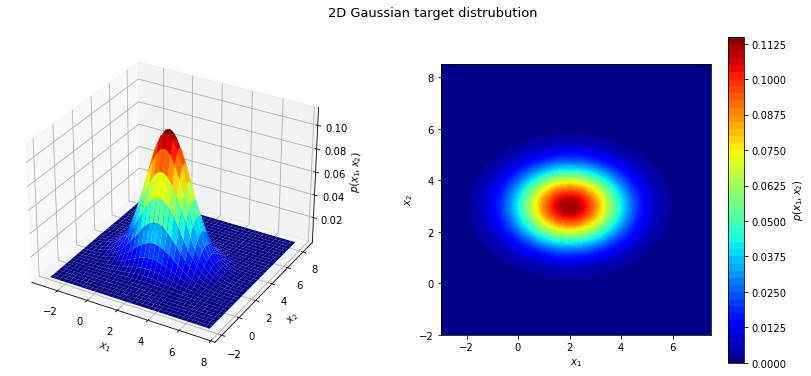

In [26]:
xaxis31 = np.arange(-5, 5.5+0.1, 0.1)
# create a mesh from the axis
xx31 = np.meshgrid(2+xaxis31, 3+xaxis31)
# compute targets
eval_obj31 = objective31(xx31)    
# Plot
plot_objective(xx31, eval_obj31, '2D Gaussian target distrubution')

## Sample from objective function

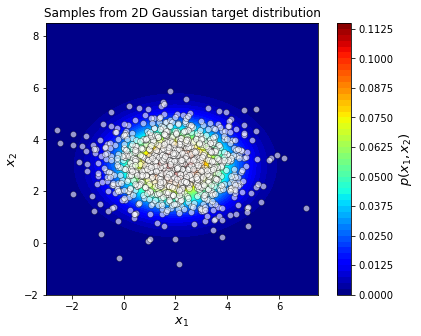

In [27]:
np.random.seed(123)
# Nsamp31 = 200
Nsamp31 = 1000
Y31 = sample_objective31(Nsamp31) # design ma

# Plot the samples and the distribution
fig, ax = plt.subplots(figsize=(7, 5))
con = ax.contourf(xx31[0], xx31[1], eval_obj31, levels=50, cmap='jet')
# Plot samples
ax.plot(Y31[0,:], Y31[1,:], 'wo', alpha=.6, markeredgecolor='k', markeredgewidth=0.5)
ax.set_xlabel('$x_1$', fontsize=13)
ax.set_ylabel('$x_2$', fontsize=13)
ax.set_aspect('equal')
ax.set_title('Samples from 2D Gaussian target distribution')
cbar = plt.colorbar(con)
cbar.ax.set_ylabel('$p(x_1, x_2)$', fontsize=13)
plt.show()

## Target distribution

The target distribution for this assessment is the unnormalized parameter posterior distribution, which is composed of the data likelihood and weakly infromative Gaussian and Gamma distributed parameter priors, respectively, i.e.,

$$
p(\boldsymbol\theta|\mathcal{D}) \propto \mathcal{N}(y|\boldsymbol\mu, \boldsymbol\Sigma) \prod_m \mathcal{N}(\mu_m|0,10) \mathcal{Gam}(\sigma_m^2|2,2)
$$

Note that we use the log-transform of the expression above for numerical stability.

## Correct, inefficient implementation

Again, we start by sampling from our target distribution with a Gaussian random walk Metropolis algorithm.

In [28]:
def log_pos31(pam, data=Y31):
    mu = pam[:2]
    sig2s = pam[2:]
    if sum( sig2s < 0 ) > 0:
        logPos = - np.inf
    else:
        Sigma = np.diag(sig2s)
        logPos = (sum( stats.multivariate_normal(mean = mu, cov=Sigma).logpdf(data.T) )
                  + sum( stats.norm( loc = 0, scale = 10).logpdf(mu) )
                  + sum( stats.gamma(a = 2, scale = 1).logpdf(sig2s) )
                 ) 
    return(logPos)

# log_pos31(np.array([1.,1.,1.,1.]), Y31) # test implementation

In [29]:
# Sampling
np.random.seed(42)
x31=np.ones(4); T31=20000
# samp31, counter31 = Metropolis(x31, T31, log_pos31, delta=0.125, dim=4)
samp31, counter31 = Metropolis(x31, T31, log_pos31, delta=0.05, dim=4)
print('Acceptance rate: ' , np.round(counter31/T31,3))

Acceptance rate:  0.316


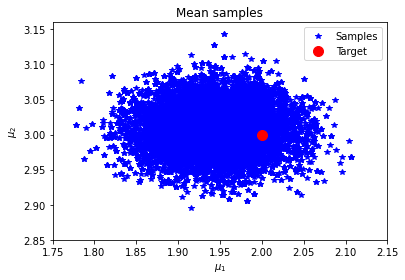

In [30]:
# Plot mean samples
def plot_mean_samp(samp):
    plt.plot(samp[1000:,0],samp[1000:,1],'*b') # a little burn-in is introduced.
    plt.plot(2,3,'or', markersize=10) # a little burn-in is introduced.
    plt.xlim([1.75, 2.15])
    plt.ylim([2.85, 3.16])
    plt.xlabel('$\mu_1$');
    plt.ylabel('$\mu_2$');
    plt.title('Mean samples')
    plt.legend(['Samples', 'Target'])
    
plot_mean_samp(samp31[:,:2])

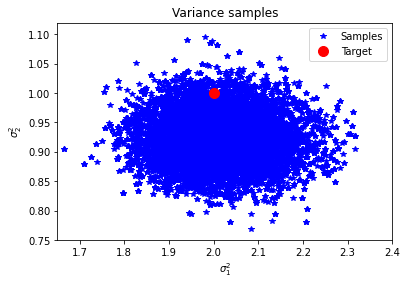

In [31]:
# Plot variance samples
def plot_var_samp(samp):
    plt.plot(samp[1000:,0],samp[1000:,1],'*b') # a little burn-in is introduced.
    plt.plot(2,1,'or', markersize=10) 
    plt.xlim([1.65, 2.4])
    plt.ylim([0.75, 1.12])
    plt.xlabel('$\sigma_1^2$');
    plt.ylabel('$\sigma_2^2$');
    plt.title('Variance samples')
    plt.legend(['Samples', 'Target'])
    
plot_var_samp(samp31[:,2:])

We see that the sampler assigns a high posterior density to the target parameters, i.e., we only observe a miner bias between the target parameters and the posterior mode.

## Correct implementation of transformation

This case study considers a mix of parameters with full support, i.e., $\{\mu_1, \mu_2\}$, and paameters with limited support (non-negative), i.e., $\{\sigma_1^2, \sigma_2^2\}$, which we want to sample in log-space, as in Case I. Further, as we saw in Case I, the multivariate change of variables principle states

$$
\begin{align}
q_{v}(\mathbf{v}) &= q_{w}(\mathbf{w}) \left| \frac{d \mathbf{w}}{d \mathbf{v}} \right| \\
&= q_{w}(g^{-1}(\mathbf{v})) \left| \text{det}(J_{v,w}) \right|^{-1},
\end{align}
$$

where $J_{v,w}$ is the Jacobian matrix of partial derivatives of $v_i$ with respect to $w_j$, i.e., $J_{v,w} = \{d v_i / d w_j\}_{i,j}$. For univeriate transforms, as in this case, $J_{v,w}$ becomes diagonal, and its determinant thus simplifies to the product of the inverse absolute value of the gradient of each transformation function. The Jacobian factor for this case thus simplifies to 

$$
\left| \text{det}(J_{v,w}) \right|^{-1} = \prod_m \left| \frac{d g_m^{-1}(v_m)}{d v_m} \right|
$$

Here, the Jacobian factor for no transform, i.e., the means, is 1, and thus there is no correction for the means. The Jacobian factor for the variances correspond to Case I, i.e., $\{ 1/\sigma_k^2 \}_{k=1}^2$. Therefore, for our case we have the following Jacobian factor:

$$
\left| \text{det}(J_{v,w}) \right|^{-1} = \prod_{k=1}^2 \left| \frac{1}{\sigma_k^2} \right|
$$

As we also saw in Case I, the log-acceptance ratio group into terms involving the proposal $\boldsymbol\theta^*$ only, and the current state $\boldsymbol\theta$ only, i.e.,

$$
\log(r_{acc}) = \left\{ \log(p(\boldsymbol\theta^*)) + \sum_{k=1}^2 \log(\sigma_k^{2*}) \right\} - \left\{ \log(p(\boldsymbol\theta)) + \sum_{k=1}^2 \log(\sigma_k^{2}) \right\},
$$

which we take advantage of in the implementation below.

In [32]:
def log_pos32(pam, data=Y31):
    mu = pam[:2]
    sig2s = np.exp(pam[2:])
    Sigma = np.diag(sig2s)
    logPos = (sum( stats.multivariate_normal(mean = mu, cov=Sigma).logpdf(data.T) )
              + sum( stats.norm( loc = 0, scale = 10).logpdf(mu) )
              + sum( stats.gamma(a = 2, scale = 1).logpdf(sig2s) )
              + sum( np.log(sig2s)) # Jacobian correction (diagonal; i.e., sum of individual log-coordinat transforms)
             )
    return(logPos)

# log_pos32(np.array([1.,1.,0.,0.]), Y31) # test implementation

In [33]:
# Sampling
np.random.seed(42)
x32=np.concatenate([np.ones(2), np.zeros(2)]); T32=20000
# samp32, counter32 = Metropolis(x32, T32, log_pos32, delta=0.125, dim=4)
samp32, counter32 = Metropolis(x32, T32, log_pos32, delta=0.05, dim=4)
print('Acceptance rate: ' , np.round(counter32/T32,3))

Acceptance rate:  0.279


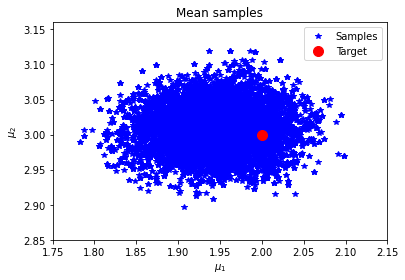

In [34]:
# Plot mean samples
plot_mean_samp(samp32[:,:2])

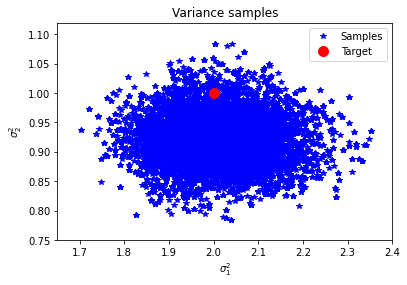

In [35]:
plot_var_samp(np.exp(samp32[:,2:]))

Again, we see that the sampler assigns a high posterior density to the target parameters, i.e., we only observe a miner bias between the target parameters and the posterior mode.

-------------

For further information and numerical examples, see the following posts;

https://umbertopicchini.wordpress.com/2017/12/18/tips-for-coding-a-metropolis-hastings-sampler/

https://darrenjw.wordpress.com/2012/06/04/metropolis-hastings-mcmc-when-the-proposal-and-target-have-differing-support/

https://umbertopicchini.files.wordpress.com/2017/12/transformed-proposals2.pdf

https://barumpark.com/blog/2019/Jacobian-Adjustments/